# Guesser

<img src="img/GuesserModel.png">

In [47]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy
import json
import matplotlib.pyplot as plt
from time import time

## Load Test Data

In [25]:
data = list()
with open('../data/guesswhat.valid.new.jsonl') as f:
    content = f.readlines()
    data = [json.loads(x.strip()) for x in content]

In [26]:
data, test = data[:1500], data[1500:1510]

## Preprocess data

### Object Embeddings

In [27]:
# get all object categories
obj_cat = set()
for d in data:
    for obj in d['objects']:
        obj_cat.add(obj['category_id'])

# create embedding for each category
obj_embed_dim = 100
obj_embends = nn.Embedding(len(obj_cat), obj_embed_dim)

catid2embedid = dict()
for i, cat in enumerate(obj_cat):
    catid2embedid[cat] = i

In [28]:
def get_obj_embeds(catid):
    """ Returns the object embedding for a category """
    return obj_embends(autograd.Variable(torch.LongTensor([catid2embedid[catid]]))).view(1,-1)

### Spatial Information

In [29]:
def get_spatial(bbox, image):
    
    # get image coordinates
    width = image['width']
    height = image['height']
    image_center_x = width / 2
    image_center_y = height / 2

    # clalc. norm. coords (between -1 and 1)
    x_min = (min(bbox[0], bbox[2]) - image_center_x) / image_center_x
    y_min = (min(bbox[1], bbox[3]) - image_center_y) / image_center_y
    x_max = (max(bbox[0], bbox[2]) - image_center_x) / image_center_x
    y_max = (max(bbox[1], bbox[3]) - image_center_y) / image_center_y
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    
    w_box = x_max - x_min
    h_box = y_max - y_min       
    
    return autograd.Variable(torch.FloatTensor([x_min, y_min, x_max, y_max, x_center, y_center, w_box, h_box]))

### Get Vocablurary

In [30]:
def preproc_question(q):
    q = q.lower()
    q = '-SOS- ' + q[:q.index('?')] + str(' ? -EOS-')
    return q

def preproc_answer(a):
    a = a.lower()
    return a

In [31]:
vocab = set()

for d in data:
    qas = d['qas']
    for qna in qas:
        question = preproc_question(qna['question'])
        vocab.update(question.split())
    
        answer = preproc_answer(qna['answer'])
        vocab.add(answer)
    

word2index = dict()
index2word = dict()
for i, w in enumerate(vocab):
    word2index[w] = i
    index2word[i] = w

print("Vocablurary created containing %i tokens." %(len(vocab)))

Vocablurary created containing 1665 tokens.


## Model

### LSTM for Question History
Takes all questions and answers as input.
Last hidden state will be used for object guessing.

#### Get Word Emebeddings

In [32]:
glove_word_embedding_size = 100

In [34]:
from torchtext.vocab import load_word_vectors

wv_dict, wv_arr, wv_size = load_word_vectors('.', 'glove.6B', glove_word_embedding_size)

print('Loaded', len(wv_arr), 'words')

loading word vectors from ./glove.6B.100d.pt
Loaded 400000 words


In [35]:
# add SOS and EOS tokens to dict
if '-SOS-' not in wv_dict:
    wv_dict['-SOS-'] = len(wv_dict)
    temp = torch.cat([wv_arr, torch.randn((1,glove_word_embedding_size))])
    wv_arr = temp
if '-EOS-' not in wv_dict:
    wv_dict['-EOS-'] = len(wv_dict)
    temp = torch.cat([wv_arr, torch.randn((1,glove_word_embedding_size))])
    wv_arr = temp

In [36]:
def get_wv(w):
    """ returning the word embedding """
    assert type(w) == str, "Not given a string."
    
    if w in wv_dict:
        vw = wv_arr[wv_dict[w]]
        return vw.view(1, glove_word_embedding_size)
    else:
        print('Word not in Vocab: %s' %(w)) 

#### Hyperparameters for LSTM

In [37]:
embedding_dim = glove_word_embedding_size
hidden_dim = 100
vocab_size = len(vocab)

#### Hyperparameters for MLP

In [39]:
d_in = 8 + obj_embed_dim # 8 comes from the spatial
d_h1 = 100
d_h2 = 50
d_out = hidden_dim # where the output dimension must match the QGen hidden state dimension!

#### LSTM Model

In [40]:
class Guesser(nn.Module):
    
    def __init__(self, embedding_dim, hidden_dim, vocab_size, d_in, d_h1, d_h2, d_out):
        super(Guesser, self).__init__()
        self.hidden_dim = hidden_dim

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden = self.init_hidden()
        
        self.object_model = nn.Sequential(
            nn.Linear(d_in, d_h1),
            nn.ReLU(),
            nn.Linear(d_h1, d_h2),
            nn.ReLU(),
            nn.Linear(d_h2, d_out)
        )

    def init_hidden(self):
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, dialogue, objects, image, training=True):
        
        # Word embedding of dialogue
        embeds = autograd.Variable(torch.FloatTensor(len(dialogue.split()), embedding_dim))
        for i, w in enumerate(dialogue.split()):
            embeds[i] = get_wv(w)
        
        
        # lstm pass
        out, self.hidden = self.lstm(embeds.view(len(dialogue.split()), 1, -1), self.hidden)
        
        
        # process objects
        proposed_embeddings = autograd.Variable(torch.zeros(len(d['objects']), hidden_dim))
        
        for i, obj in enumerate(objects):
            x = get_spatial(obj['bbox'], image).view(1,-1)
            e = get_obj_embeds(catid=obj['category_id'])
            y = torch.cat([x, e], dim=1)
            proposed_embeddings[i] = self.object_model(y)
                
        if not training:
            print(proposed_embeddings)
            print(self.hidden[0].view(hidden_dim,-1))
            
            
        # multiply lstm output with mlp output and apply softmax    
        predicted_object = F.log_softmax(torch.mm(proposed_embeddings, self.hidden[0].view(hidden_dim,-1)).t())
        
        
        return predicted_object

### Training Hyperparameters

In [41]:
iterations = 1
lr = 0.1

## Training

Epoch 0 Time 66.42 Loss 39.349316


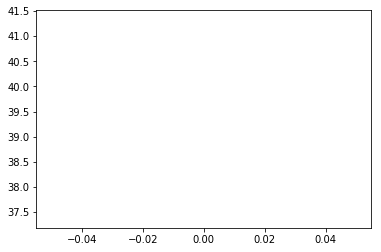

In [46]:
model = Guesser(embedding_dim=embedding_dim, hidden_dim=hidden_dim, vocab_size=vocab_size, 
                     d_in=d_in, d_h1=d_h1, d_h2=d_h2, d_out=d_out)

loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

avg_loss = list()

for epoch in range(iterations):
    _loss = list()
    start_time = time()
    for d in data:
        
        # set gradient and hidden layer back to 0
        model.zero_grad()
        model.hidden = model.init_hidden()
        
        
        # get objects
        object_ids = list()
        objects = d['objects']
        
        for i, obj in enumerate(d['objects']):
            object_ids.append(obj['id'])            
        
        # get image meta
        image = d['image']
        
        # get the lstm input
        dialogue = str()
        for qna in d['qas']:
            question = preproc_question(qna['question'])
            answer = preproc_answer(qna['answer'])
            dialogue += question + ' ' + answer + ' '
          
        
        # check if embeddings for all words in the dialogue exist
        wv_for_dialogue = True
        for w in dialogue.split():
            if w not in wv_dict:
                wv_for_dialogue = False
                break
                
        if wv_for_dialogue == False:
            continue
        
        # make prediction
        predicted_object = model(dialogue, objects, image)
        
        
        # get target
        target_id = d['object_id']
        target = autograd.Variable(torch.LongTensor([object_ids.index(target_id)]))
        
        # calculate loss
        loss = loss_function(predicted_object, target)
        loss.backward()
        optimizer.step()           
        
        
        # bookkeeping
        _loss.append(loss.data.numpy())
        
    avg_loss.append(numpy.mean(_loss))
    print('Epoch %i Time %.2f Loss %f' %(epoch, time()-start_time, avg_loss[-1]))

plt.plot(avg_loss)
plt.show()

## Testing

In [44]:
d = test[2]
object_ids = list()
objects = d['objects']

for i, obj in enumerate(d['objects']):
    object_ids.append(obj['id'])            


# get the lstm input
dialogue = str()
for qna in d['qas']:
    question = preproc_question(qna['question'])
    answer = preproc_answer(qna['answer'])
    dialogue += question + ' ' + answer + ' '
    
target_id = d['object_id']
target = autograd.Variable(torch.LongTensor([object_ids.index(target_id)]))
print(target)

Variable containing:
 4
[torch.LongTensor of size 1]



In [19]:
model(dialogue, objects, training=True)

Variable containing:

Columns 0 to 5 
-5.2902e-02 -1.0598e-01 -1.1161e-02  5.2882e-02 -4.0427e-02  6.5104e-02
-5.2902e-02 -1.0598e-01 -1.1161e-02  5.2882e-02 -4.0427e-02  6.5104e-02
-5.2902e-02 -1.0598e-01 -1.1161e-02  5.2882e-02 -4.0427e-02  6.5104e-02
-5.2902e-02 -1.0598e-01 -1.1161e-02  5.2882e-02 -4.0427e-02  6.5104e-02
-5.2902e-02 -1.0598e-01 -1.1161e-02  5.2882e-02 -4.0427e-02  6.5104e-02
-5.2902e-02 -1.0598e-01 -1.1161e-02  5.2882e-02 -4.0427e-02  6.5104e-02
-5.2902e-02 -1.0598e-01 -1.1161e-02  5.2882e-02 -4.0427e-02  6.5104e-02

Columns 6 to 11 
-1.8639e-02  9.5920e-02  1.1119e-02 -8.4981e-02  4.3430e-02  9.4486e-03
-1.8639e-02  9.5920e-02  1.1119e-02 -8.4981e-02  4.3430e-02  9.4486e-03
-1.8639e-02  9.5920e-02  1.1119e-02 -8.4981e-02  4.3430e-02  9.4486e-03
-1.8639e-02  9.5920e-02  1.1119e-02 -8.4981e-02  4.3430e-02  9.4486e-03
-1.8639e-02  9.5920e-02  1.1119e-02 -8.4981e-02  4.3430e-02  9.4486e-03
-1.8639e-02  9.5920e-02  1.1119e-02 -8.4981e-02  4.3430e-02  9.4486e-03
-1.8639e

Variable containing:
-1.9459 -1.9459 -1.9459 -1.9459 -1.9459 -1.9459 -1.9459
[torch.FloatTensor of size 1x7]

In [23]:
import torch
x = torch.Tensor([[1,2,3,4]])
y = torch.Tensor([[5,6,7,8]])
z = torch.cat([x,y], dim=0)
print(z)
z = torch.cat([x,y], dim=1)
print(z)
x = torch.cat([x,y],dim=0)
print(x)


 1  2  3  4
 5  6  7  8
[torch.FloatTensor of size 2x4]


    1     2     3     4     5     6     7     8
[torch.FloatTensor of size 1x8]


 1  2  3  4
 5  6  7  8
[torch.FloatTensor of size 2x4]

